# 🧠 Age Classification from fMRI Graphs using GCN

### 📘 Project Overview

This project explores the use of **Graph Neural Networks (GNNs)**—specifically, **Graph Convolutional Networks (GCNs)**—to classify subjects as **children** or **adults** based on their resting-state **functional Magnetic Resonance Imaging (fMRI)** data.

Each subject's brain is represented as a **graph**, where:
- **Nodes** correspond to brain regions of interest (ROIs)
- **Edges** capture functional connectivity between these regions
- **Node features** are derived from the subject’s correlation matrix

The project evaluates different ways to construct these graphs using:
- **Pearson Correlation**
- **Partial Correlation**
- **Tangent Correlation**

Each method is tested across multiple **thresholds** to control graph sparsity. The goal is to determine which combination of correlation type and threshold provides the best classification performance, especially in correctly identifying adults (minority class).

### 📌 Goals
- Construct brain graphs from fMRI time series
- Train a GCN model to classify between children and adults
- Compare performance across different correlation matrices and thresholds
- Optimize for both accuracy and recall, with a focus on adult recall

---

Let’s begin by importing packages and loading the dataset.


# 1. Import Libraries 

In [1]:
# --- Step 1: Import necessary libraries ---

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

print("Libraries imported successfully.")


Libraries imported successfully.


# 2. Load fMRI Data and Labels

In [2]:
# --- Step 2: Load the fMRI time series data and labels ---

import os

# Define base directory where the fMRI time series data is stored
data_dir = os.path.expanduser("~/time_series_data")
n_subjects = 155

# Load subject labels (0 = child, 1 = adult)
labels_path = os.path.join(data_dir, "subject_labels.npy")
subject_labels = np.load(labels_path)

# Load time-series data for each subject
pooled_subjects = []
for idx in range(n_subjects):
    file_path = os.path.join(data_dir, f"subject_{idx}.npz")
    data = np.load(file_path)
    time_series = data["time_series"]  # (168 timepoints × 39 ROIs)
    pooled_subjects.append(time_series)

# Check shapes
print(f"✅ Loaded {len(pooled_subjects)} time-series with label shape {subject_labels.shape}")
print(f"📐 First subject time-series shape: {pooled_subjects[0].shape}")


✅ Loaded 155 time-series with label shape (155,)
📐 First subject time-series shape: (168, 39)


# 3. Compute Correlation Matrices from Time Series

In [3]:
# --- Step 3: Compute correlation matrices for each subject ---

from nilearn.connectome import ConnectivityMeasure

# Initialize a correlation calculator from nilearn
correlation_measure = ConnectivityMeasure(kind='correlation')

# List to store the correlation matrices
correlation_matrices = []

for idx, time_series in enumerate(pooled_subjects):
    # time_series: shape (168, 39)
    
    # Compute correlation matrix
    corr = correlation_measure.fit_transform([time_series])[0]  # (39, 39)
    
    # Optional: set diagonal to 1 (perfect self-correlation)
    np.fill_diagonal(corr, 1.0)
    
    # Append to list
    correlation_matrices.append(corr)

print(f"✅ Computed {len(correlation_matrices)} correlation matrices.")
print(f"📐 Example correlation matrix shape: {correlation_matrices[0].shape}")


✅ Computed 155 correlation matrices.
📐 Example correlation matrix shape: (39, 39)


# 4. Build Graph Data Objects

In [4]:
# --- Step 4: Build PyTorch Geometric Data objects (graphs) for each subject ---

graph_list = []

# Define threshold percentage (higher = denser graph)
threshold_percent = 5  # adjust this if needed later

for corr, label in zip(correlation_matrices, subject_labels):
    # Convert correlation matrix to tensor
    corr_tensor = torch.tensor(corr, dtype=torch.float)

    # Create a copy to threshold for edges
    adj_matrix = corr.copy()
    
    # Threshold: keep top threshold_percent of positive correlations
    positive_corrs = adj_matrix[adj_matrix > 0]
    thresh_value = np.percentile(positive_corrs, 100 - threshold_percent)
    
    adj_matrix[adj_matrix < thresh_value] = 0
    adj_matrix[adj_matrix >= thresh_value] = 1

    # Create edge_index
    edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)

    # Create PyG Data object
    data = Data(x=corr_tensor, edge_index=edge_index, y=torch.tensor(label, dtype=torch.long))
    
    graph_list.append(data)

print(f"✅ Created {len(graph_list)} graph data objects.")


✅ Created 155 graph data objects.


# 5. Train/Test Split

In [5]:
# --- Step 5: Split the graph data into training and testing sets ---

# Split 80% for training, 20% for testing
train_graphs, test_graphs = train_test_split(
    graph_list,
    test_size=0.2,
    random_state=42,
    stratify=subject_labels  # to preserve class balance
)

print(f"✅ Training set size: {len(train_graphs)} graphs")
print(f"✅ Testing set size: {len(test_graphs)} graphs")


✅ Training set size: 124 graphs
✅ Testing set size: 31 graphs


# 6. Create DataLoaders for Training and Testing

In [6]:
# --- Step 6: Create DataLoaders for batching during training ---

batch_size = 16  

train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)

print(f"✅ DataLoaders created with batch size {batch_size}.")


✅ DataLoaders created with batch size 16.


/Users/anushamourshed/miniconda3/envs/capstone/lib/python3.11/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# 7. Define and Instantiate the GCN Model

## 🧠 GCN Model Architecture Overview

This Graph Convolutional Network (GCN) is designed for graph classification using brain functional connectivity graphs derived from fMRI data.

### 📐 Model Structure
- **Input:** Graphs with 39 nodes (brain regions), each with 39-dimensional node features (the correlation values with other regions).
- **Layers:**
  1. **GCNConv 1**: Input dim = 39, Hidden dim = 64  
     Applies graph convolution and ReLU activation.
  2. **GCNConv 2**: Hidden dim = 64 → Hidden dim = 64  
     Applies another graph convolution followed by ReLU.
  3. **Global Mean Pooling:**  
     Aggregates node features by averaging across all nodes in each graph to form a graph-level embedding.
  4. **Linear Layer (FC):** Hidden dim = 64 → Output dim = 2  
     Predicts class scores (e.g., child vs. adult).

### 🧩 Input Definitions
- **Node Features (`x`)**: Each node (ROI) has a 39-dimensional feature vector representing correlations with all other ROIs.
- **Edge Index (`edge_index`)**: Specifies the connections between nodes. Edges are created based on a thresholded correlation matrix.
- **Batch Vector (`batch`)**: Used to indicate which graph each node belongs to during batching.

### 🔄 Output
- The final output is a tensor of shape `(num_graphs, num_classes)` containing raw class scores for each graph.



In [7]:
# --- Step 7: Define a simple GCN model for graph classification ---

from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GCN, self).__init__()
        
        # GCN layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        # Fully connected layer for classification
        self.fc = torch.nn.Linear(hidden_dim, num_classes)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # 1st GCN layer + activation
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        # 2nd GCN layer + activation
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Global mean pooling (average over nodes)
        x = global_mean_pool(x, batch)

        # Final classification layer
        out = self.fc(x)
        return out

print("✅ GCN model defined.")

# --- Step 9.1: Instantiate the model, optimizer, and loss function ---

# Set device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

# Define input, hidden, and output sizes
input_dim = correlation_matrices[0].shape[1]  # 39 features
hidden_dim = 64
num_classes = 2  # Child vs Adult

# Instantiate model
model = GCN(input_dim, hidden_dim, num_classes).to(device)

# Compute class weights from your original label array
labels_np = np.array(subject_labels)  # Make sure `subject_labels` is available
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_np), y=labels_np)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define optimizer with L2 regularization (weight decay)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)

# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

print("✅ Model, optimizer, and loss function are ready.")


✅ GCN model defined.
✅ Using device: cpu
✅ Model, optimizer, and loss function are ready.


# 8. Train the GCN Model

In [39]:
# --- Step 8: Train the GCN model with Loss Tracking ---

num_epochs = 30
train_losses = []  # 🔹 Store training loss for each epoch

for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0
    
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        out = model(batch)
        loss = criterion(out, batch.y.long())  # 🔹 Ensure labels are Long type
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)  # 🔹 Save loss
    print(f"Epoch {epoch:02d} | Loss: {avg_loss:.4f}")


Epoch 01 | Loss: 0.1259
Epoch 02 | Loss: 0.1169
Epoch 03 | Loss: 0.1148
Epoch 04 | Loss: 0.1184
Epoch 05 | Loss: 0.1000
Epoch 06 | Loss: 0.0980
Epoch 07 | Loss: 0.0918
Epoch 08 | Loss: 0.0879
Epoch 09 | Loss: 0.0880
Epoch 10 | Loss: 0.0748
Epoch 11 | Loss: 0.0728
Epoch 12 | Loss: 0.0716
Epoch 13 | Loss: 0.0657
Epoch 14 | Loss: 0.0642
Epoch 15 | Loss: 0.0596
Epoch 16 | Loss: 0.0558
Epoch 17 | Loss: 0.0540
Epoch 18 | Loss: 0.0509
Epoch 19 | Loss: 0.0501
Epoch 20 | Loss: 0.0470
Epoch 21 | Loss: 0.0439
Epoch 22 | Loss: 0.0412
Epoch 23 | Loss: 0.0411
Epoch 24 | Loss: 0.0390
Epoch 25 | Loss: 0.0356
Epoch 26 | Loss: 0.0328
Epoch 27 | Loss: 0.0319
Epoch 28 | Loss: 0.0314
Epoch 29 | Loss: 0.0291
Epoch 30 | Loss: 0.0272


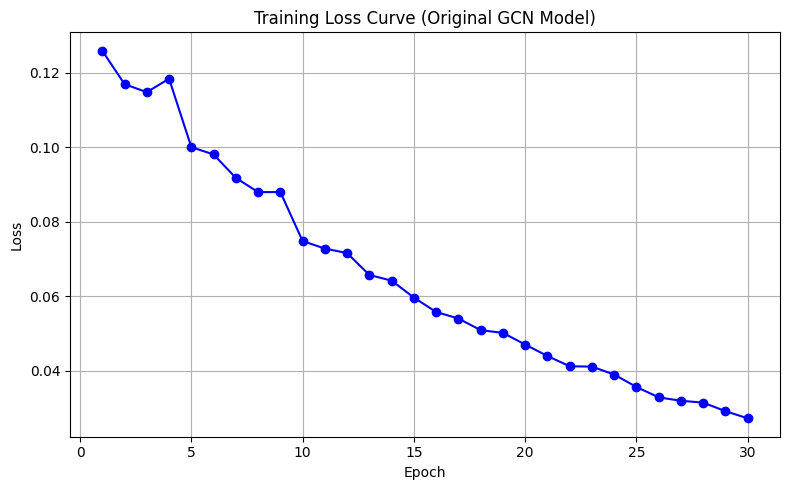

In [40]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', color='blue')
plt.title("Training Loss Curve (Original GCN Model)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


# 9. Evaluate the GCN Model on Test Set

✅ Classification Report:

              precision    recall  f1-score   support

           0     0.9545    0.8750    0.9130        24
           1     0.6667    0.8571    0.7500         7

    accuracy                         0.8710        31
   macro avg     0.8106    0.8661    0.8315        31
weighted avg     0.8895    0.8710    0.8762        31

✅ Confusion Matrix (raw values):

[[21  3]
 [ 1  6]]


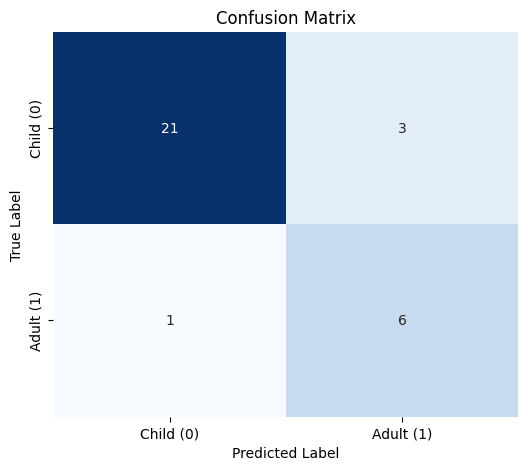

In [9]:
# --- Step 9: Test the model and visualize confusion matrix ---

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        
        # Forward pass
        out = model(batch)
        
        # Predicted classes
        preds = out.argmax(dim=1)
        
        y_true.append(batch.y.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

# Flatten lists
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Classification report
print("✅ Classification Report:\n")
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("✅ Confusion Matrix (raw values):\n")
print(cm)

# --- Plot the confusion matrix ---
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Child (0)', 'Adult (1)'], 
            yticklabels=['Child (0)', 'Adult (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


# 10. Save the Correlation Matrices

In [10]:
# --- Save the correlation matrices from this run ---

np.save('corr_matrices_saved.npy', np.array(correlation_matrices))

print("✅ Correlation matrices from this run saved successfully!")



✅ Correlation matrices from this run saved successfully!


# ========================================================
# 📚 New Experiment: Multi-correlation Types (Correlation, Partial, Tangent)
# ========================================================


# 1. Compute Partial and Tangent Matrices



In this step, we compute two additional types of functional connectivity matrices:

---

## 🔹 Partial Correlation Matrices

- Partial correlation measures the relationship between two brain regions while **controlling for all other regions**.
- Each subject’s time series is processed **individually**.
- Computed using `ConnectivityMeasure(kind='partial correlation')` from nilearn.

✅ For each subject:
- One (39 × 39) partial correlation matrix is generated.
- Diagonal is set to 1 (perfect self-correlation).

---

## 🔹 Tangent Matrices

- Tangent embedding maps covariance matrices into a **tangent space around a mean covariance matrix**.
- **Requires all subjects together** to estimate the mean model.
- Computed using `ConnectivityMeasure(kind='tangent')` across the full dataset.

✅ Important:
- Unlike correlation and partial correlation, **tangent matrices cannot be computed individually per subject**.
- We fit the tangent model on the full list of subjects’ time series.
- After computing, we set the diagonal to 1 for each tangent matrix.

---

## ✅ Output:
- `partial_corr_matrices`: list of 155 partial correlation matrices.
- `tangent_matrices`: list of 155 tangent space matrices.

---

## 📌 Note:
- Partial correlation → loop through subjects one by one.
- Tangent → fit once across all subjects together.


In [11]:
# --- Step 1: Compute Partial Correlation and Tangent matrices properly ---

from nilearn.connectome import ConnectivityMeasure

# Initialize calculators
partial_corr_measure = ConnectivityMeasure(kind='partial correlation')
tangent_measure = ConnectivityMeasure(kind='tangent')

# Lists to store matrices
partial_corr_matrices = []

# --- Partial correlation (subject-by-subject) ---
for idx, time_series in enumerate(pooled_subjects):
    partial = partial_corr_measure.fit_transform([time_series])[0]
    np.fill_diagonal(partial, 1.0)
    partial_corr_matrices.append(partial)

print(f"✅ Computed {len(partial_corr_matrices)} partial correlation matrices.")

# --- Tangent (fit all subjects together) ---
all_time_series = [ts for ts in pooled_subjects]  # 155 subjects
tangent_matrices = tangent_measure.fit_transform(all_time_series)

# Set diagonal to 1 for each tangent matrix
for tangent in tangent_matrices:
    np.fill_diagonal(tangent, 1.0)

print(f"✅ Computed {len(tangent_matrices)} tangent matrices.")


✅ Computed 155 partial correlation matrices.
✅ Computed 155 tangent matrices.


# 2. Save Partial and Tangent Matrices

In [12]:
# --- Step 2: Save partial and tangent matrices to .npy files ---

np.save('partial_corr_matrices_saved.npy', np.array(partial_corr_matrices))
np.save('tangent_matrices_saved.npy', np.array(tangent_matrices))

print("✅ Saved partial_corr_matrices_saved.npy")
print("✅ Saved tangent_matrices_saved.npy")


✅ Saved partial_corr_matrices_saved.npy
✅ Saved tangent_matrices_saved.npy


# 3. Build Graph Data Objects for Partial and Tangent Matrices

In [25]:
# --- Step 3: Build graph data objects for partial and tangent matrices ---

# Set the threshold percent (you can keep 5% as before)
threshold_percent = 5

# Helper function to build graphs
def build_graphs(matrix_list, label_list, threshold_percent):
    graphs = []
    for corr, label in zip(matrix_list, label_list):
        corr_tensor = torch.tensor(corr, dtype=torch.float)

        adj_matrix = corr.copy()
        positive_corrs = adj_matrix[adj_matrix > 0]
        thresh_value = np.percentile(positive_corrs, 100 - threshold_percent)

        adj_matrix[adj_matrix < thresh_value] = 0
        adj_matrix[adj_matrix >= thresh_value] = 1

        edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)

        data = Data(x=corr_tensor, edge_index=edge_index, y=torch.tensor(label, dtype=torch.long))
        graphs.append(data)
    
    return graphs

# --- Build graphs ---

graph_list_partial = build_graphs(partial_corr_matrices, subject_labels, threshold_percent)
graph_list_tangent = build_graphs(tangent_matrices, subject_labels, threshold_percent)

print(f"✅ Created {len(graph_list_partial)} graphs from partial correlation matrices.")
print(f"✅ Created {len(graph_list_tangent)} graphs from tangent matrices.")


✅ Created 155 graphs from partial correlation matrices.
✅ Created 155 graphs from tangent matrices.


# 4. Train/Test Split for Partial and Tangent Graphs

In [26]:
# --- Step 4: Split partial and tangent graphs into training and testing sets ---

from sklearn.model_selection import train_test_split

# Split 80% train, 20% test
train_graphs_partial, test_graphs_partial = train_test_split(
    graph_list_partial,
    test_size=0.2,
    random_state=42,
    stratify=subject_labels
)

train_graphs_tangent, test_graphs_tangent = train_test_split(
    graph_list_tangent,
    test_size=0.2,
    random_state=42,
    stratify=subject_labels
)

print(f"✅ Partial correlation graphs: {len(train_graphs_partial)} train / {len(test_graphs_partial)} test")
print(f"✅ Tangent graphs: {len(train_graphs_tangent)} train / {len(test_graphs_tangent)} test")


✅ Partial correlation graphs: 124 train / 31 test
✅ Tangent graphs: 124 train / 31 test


# 5. Create DataLoaders for Partial and Tangent Graphs

In [27]:
# --- Step 5: Create DataLoaders for partial and tangent graphs ---

from torch_geometric.loader import DataLoader  # (use loader instead of deprecated data)

batch_size = 16  # Same batch size as before

# Partial correlation loaders
train_loader_partial = DataLoader(train_graphs_partial, batch_size=batch_size, shuffle=True)
test_loader_partial = DataLoader(test_graphs_partial, batch_size=batch_size, shuffle=False)

# Tangent loaders
train_loader_tangent = DataLoader(train_graphs_tangent, batch_size=batch_size, shuffle=True)
test_loader_tangent = DataLoader(test_graphs_tangent, batch_size=batch_size, shuffle=False)

print(f"✅ DataLoaders created for partial and tangent graphs (batch size {batch_size}).")


✅ DataLoaders created for partial and tangent graphs (batch size 16).


# 6. Set up the GCN model

In [28]:
# --- Step 6: Define and instantiate fresh GCN models for partial and tangent ---

from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
from sklearn.utils.class_weight import compute_class_weight

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ Using device: {device}")

# Model parameters
input_dim = 39  # Number of ROIs
hidden_dim = 64
num_classes = 2
weight_decay = 0.0005

# Compute class weights (reuse subject_labels)
labels_np = np.array(subject_labels)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels_np), y=labels_np)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.fc = torch.nn.Linear(hidden_dim, num_classes)
    
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = global_mean_pool(x, batch)
        return self.fc(x)

# Instantiate models
model_partial = GCN(input_dim, hidden_dim, num_classes).to(device)
model_tangent = GCN(input_dim, hidden_dim, num_classes).to(device)

# Optimizers with weight decay
optimizer_partial = torch.optim.Adam(model_partial.parameters(), lr=0.001, weight_decay=weight_decay)
optimizer_tangent = torch.optim.Adam(model_tangent.parameters(), lr=0.001, weight_decay=weight_decay)

# Loss function with class weights
criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor)

print("✅ Models, optimizers, and loss function ready for partial and tangent graphs.")


✅ Using device: cpu
✅ Models, optimizers, and loss function ready for partial and tangent graphs.


# 7. Train on partial graphs first

In [29]:
# --- Step 7: Train GCN on Partial Correlation graphs with Loss Tracking ---

num_epochs = 30
partial_train_losses = []  # 🔹 Store avg loss per epoch

for epoch in range(1, num_epochs + 1):
    model_partial.train()
    total_loss = 0
    
    for batch in train_loader_partial:
        batch = batch.to(device)
        optimizer_partial.zero_grad()
        
        out = model_partial(batch)
        loss = criterion(out, batch.y.long())
        
        loss.backward()
        optimizer_partial.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader_partial)
    partial_train_losses.append(avg_loss)  # 🔹 Track this value
    print(f"[Partial] Epoch {epoch:02d} | Loss: {avg_loss:.4f}")


[Partial] Epoch 01 | Loss: 0.6957
[Partial] Epoch 02 | Loss: 0.6904
[Partial] Epoch 03 | Loss: 0.6931
[Partial] Epoch 04 | Loss: 0.6910
[Partial] Epoch 05 | Loss: 0.6906
[Partial] Epoch 06 | Loss: 0.6909
[Partial] Epoch 07 | Loss: 0.6866
[Partial] Epoch 08 | Loss: 0.6901
[Partial] Epoch 09 | Loss: 0.6861
[Partial] Epoch 10 | Loss: 0.6850
[Partial] Epoch 11 | Loss: 0.6831
[Partial] Epoch 12 | Loss: 0.6838
[Partial] Epoch 13 | Loss: 0.6845
[Partial] Epoch 14 | Loss: 0.6816
[Partial] Epoch 15 | Loss: 0.6823
[Partial] Epoch 16 | Loss: 0.6807
[Partial] Epoch 17 | Loss: 0.6770
[Partial] Epoch 18 | Loss: 0.6749
[Partial] Epoch 19 | Loss: 0.6760
[Partial] Epoch 20 | Loss: 0.6759
[Partial] Epoch 21 | Loss: 0.6731
[Partial] Epoch 22 | Loss: 0.6705
[Partial] Epoch 23 | Loss: 0.6657
[Partial] Epoch 24 | Loss: 0.6657
[Partial] Epoch 25 | Loss: 0.6661
[Partial] Epoch 26 | Loss: 0.6627
[Partial] Epoch 27 | Loss: 0.6551
[Partial] Epoch 28 | Loss: 0.6526
[Partial] Epoch 29 | Loss: 0.6422
[Partial] Epoc

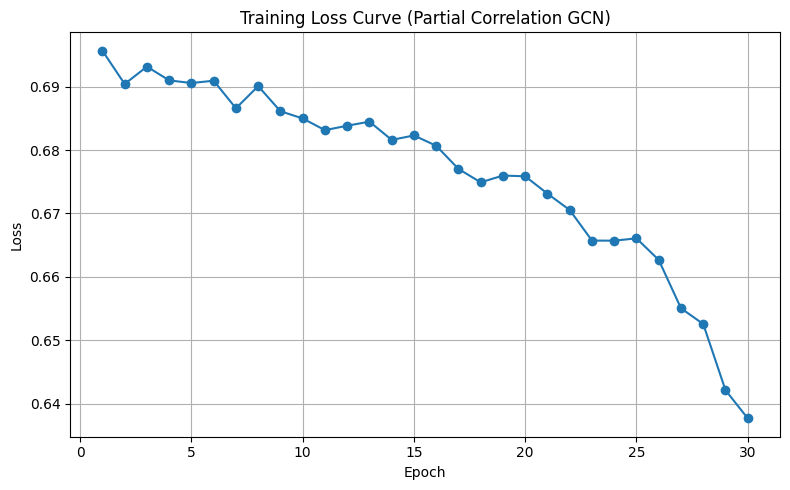

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), partial_train_losses, marker='o')
plt.title("Training Loss Curve (Partial Correlation GCN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


# 8. Evaluate Model on Partial Correlation Graphs

✅ Classification Report (Partial Correlation Graphs):

              precision    recall  f1-score   support

           0     0.7742    1.0000    0.8727        24
           1     0.0000    0.0000    0.0000         7

    accuracy                         0.7742        31
   macro avg     0.3871    0.5000    0.4364        31
weighted avg     0.5994    0.7742    0.6757        31

✅ Confusion Matrix (Partial Correlation Graphs):

[[24  0]
 [ 7  0]]


/Users/anushamourshed/miniconda3/envs/capstone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anushamourshed/miniconda3/envs/capstone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anushamourshed/miniconda3/envs/capstone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

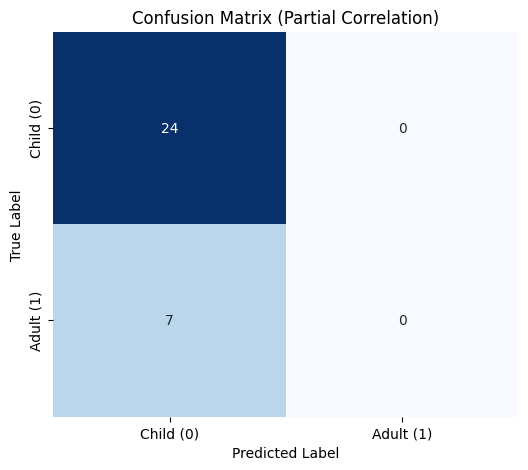

In [31]:
# --- Step 8: Evaluate the GCN model trained on Partial Correlation graphs ---

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Evaluation
model_partial.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader_partial:
        batch = batch.to(device)
        out = model_partial(batch)
        preds = out.argmax(dim=1)
        y_true.append(batch.y.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

# Flatten the lists
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Classification report
print("✅ Classification Report (Partial Correlation Graphs):\n")
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("✅ Confusion Matrix (Partial Correlation Graphs):\n")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Child (0)', 'Adult (1)'],
            yticklabels=['Child (0)', 'Adult (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Partial Correlation)')
plt.show()


# 9. Train Model on Tangent Correlation Graphs

In [33]:
# --- Step 9: Train GCN on Tangent Correlation graphs with Loss Tracking ---

num_epochs = 30
tangent_train_losses = []  # 🔹 Track average training loss per epoch

for epoch in range(1, num_epochs + 1):
    model_tangent.train()
    total_loss = 0
    
    for batch in train_loader_tangent:
        batch = batch.to(device)
        optimizer_tangent.zero_grad()
        
        out = model_tangent(batch)
        loss = criterion(out, batch.y.long())
        
        loss.backward()
        optimizer_tangent.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader_tangent)
    tangent_train_losses.append(avg_loss)  # 🔹 Save loss
    print(f"[Tangent] Epoch {epoch:02d} | Loss: {avg_loss:.4f}")



[Tangent] Epoch 01 | Loss: 0.1134
[Tangent] Epoch 02 | Loss: 0.0981
[Tangent] Epoch 03 | Loss: 0.0904
[Tangent] Epoch 04 | Loss: 0.0805
[Tangent] Epoch 05 | Loss: 0.0740
[Tangent] Epoch 06 | Loss: 0.0690
[Tangent] Epoch 07 | Loss: 0.0654
[Tangent] Epoch 08 | Loss: 0.0563
[Tangent] Epoch 09 | Loss: 0.0512
[Tangent] Epoch 10 | Loss: 0.0480
[Tangent] Epoch 11 | Loss: 0.0457
[Tangent] Epoch 12 | Loss: 0.0403
[Tangent] Epoch 13 | Loss: 0.0376
[Tangent] Epoch 14 | Loss: 0.0347
[Tangent] Epoch 15 | Loss: 0.0336
[Tangent] Epoch 16 | Loss: 0.0307
[Tangent] Epoch 17 | Loss: 0.0273
[Tangent] Epoch 18 | Loss: 0.0265
[Tangent] Epoch 19 | Loss: 0.0267
[Tangent] Epoch 20 | Loss: 0.0231
[Tangent] Epoch 21 | Loss: 0.0225
[Tangent] Epoch 22 | Loss: 0.0234
[Tangent] Epoch 23 | Loss: 0.0211
[Tangent] Epoch 24 | Loss: 0.0208
[Tangent] Epoch 25 | Loss: 0.0180
[Tangent] Epoch 26 | Loss: 0.0188
[Tangent] Epoch 27 | Loss: 0.0168
[Tangent] Epoch 28 | Loss: 0.0168
[Tangent] Epoch 29 | Loss: 0.0162
[Tangent] Epoc

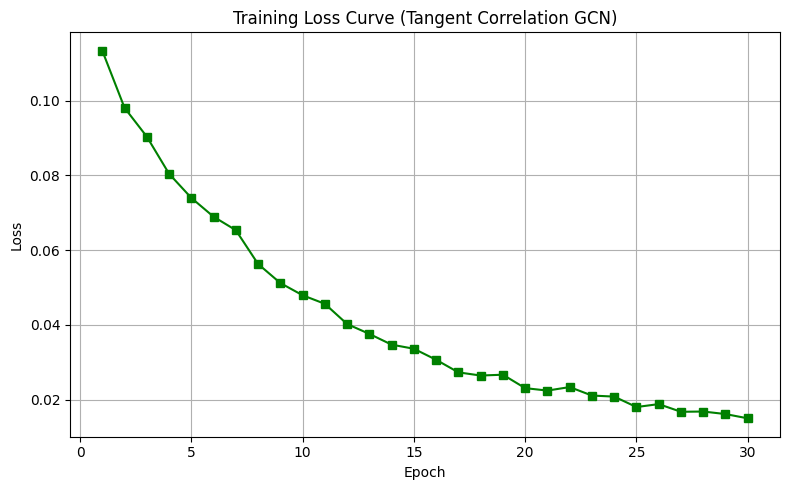

In [34]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), tangent_train_losses, marker='s', color='green')
plt.title("Training Loss Curve (Tangent Correlation GCN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()


# 10. Evaluate Model in Tangent Correlation Graphs

✅ Classification Report (Tangent Correlation Graphs):

              precision    recall  f1-score   support

           0     0.8889    1.0000    0.9412        24
           1     1.0000    0.5714    0.7273         7

    accuracy                         0.9032        31
   macro avg     0.9444    0.7857    0.8342        31
weighted avg     0.9140    0.9032    0.8929        31

✅ Confusion Matrix (Tangent Correlation Graphs):

[[24  0]
 [ 3  4]]


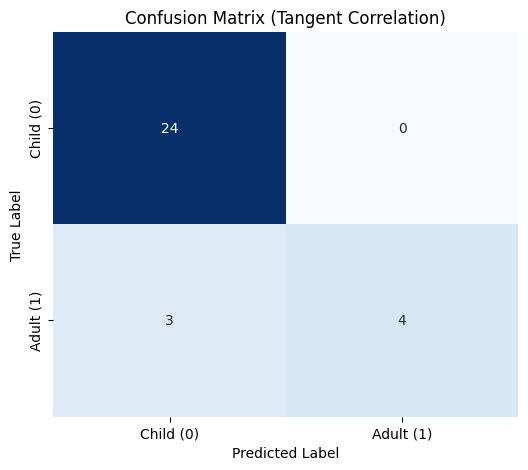

In [35]:
# --- Step 10: Evaluate the GCN model trained on Tangent Correlation graphs ---

# Evaluation
model_tangent.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for batch in test_loader_tangent:
        batch = batch.to(device)
        out = model_tangent(batch)
        preds = out.argmax(dim=1)
        y_true.append(batch.y.cpu().numpy())
        y_pred.append(preds.cpu().numpy())

# Flatten the lists
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Classification report
print("✅ Classification Report (Tangent Correlation Graphs):\n")
print(classification_report(y_true, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("✅ Confusion Matrix (Tangent Correlation Graphs):\n")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Child (0)', 'Adult (1)'],
            yticklabels=['Child (0)', 'Adult (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Tangent Correlation)')
plt.show()


# 11. Train on All Correlation Types and Thresholds

In [36]:
# --- Reload the saved correlation matrices ---

import numpy as np

# Load the saved matrices
corr_matrices = np.load('corr_matrices_saved.npy', allow_pickle=True)
partial_corr_matrices = np.load('partial_corr_matrices_saved.npy', allow_pickle=True)
tangent_matrices = np.load('tangent_matrices_saved.npy', allow_pickle=True)

print("✅ Reloaded saved correlation, partial, and tangent matrices.")
print(f"Shapes: {corr_matrices.shape}, {partial_corr_matrices.shape}, {tangent_matrices.shape}")


✅ Reloaded saved correlation, partial, and tangent matrices.
Shapes: (155, 39, 39), (155, 39, 39), (155, 39, 39)


In [37]:
# --- Full Loop: Train and evaluate over all correlation types and thresholds ---

# Available matrices
correlation_types = {
    'correlation': corr_matrices,
    'partial': partial_corr_matrices,
    'tangent': tangent_matrices
}

# Thresholds to test
thresholds = [0.2, 0.4, 0.6, 0.8]

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Save results
results = []

# Helper function to build graphs
def build_graphs(matrix_list, label_list, threshold_value):
    graphs = []
    for corr, label in zip(matrix_list, label_list):
        corr_tensor = torch.tensor(corr, dtype=torch.float)

        adj_matrix = corr.copy()
        positive_corrs = adj_matrix[adj_matrix > 0]
        if len(positive_corrs) == 0:
            continue  # skip empty matrices
        thresh_value = np.percentile(positive_corrs, 100 - (threshold_value * 100))

        adj_matrix[adj_matrix < thresh_value] = 0
        adj_matrix[adj_matrix >= thresh_value] = 1

        edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)

        data = Data(x=corr_tensor, edge_index=edge_index, y=torch.tensor(label, dtype=torch.long))
        graphs.append(data)
    return graphs

# Loop over correlation types and thresholds
for corr_type, matrix_list in correlation_types.items():
    for threshold in thresholds:
        print(f"\n🚀 Training with {corr_type} | Threshold: {threshold}")

        # Build graphs
        graph_list = build_graphs(matrix_list, subject_labels, threshold)

        # Train/test split
        train_graphs, test_graphs = train_test_split(
            graph_list, test_size=0.2, random_state=42, stratify=subject_labels
        )

        # Create DataLoaders
        train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
        test_loader = DataLoader(test_graphs, batch_size=16, shuffle=False)

        # Define fresh model
        input_dim = 39
        hidden_dim = 64
        num_classes = 2
        model = GCN(input_dim, hidden_dim, num_classes).to(device)

        # Optimizer and loss
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = torch.nn.CrossEntropyLoss()

        # Train model
        num_epochs = 30
        for epoch in range(1, num_epochs + 1):
            model.train()
            total_loss = 0
            for batch in train_loader:
                batch = batch.to(device)
                optimizer.zero_grad()
                out = model(batch)
                loss = criterion(out, batch.y)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)

        # Evaluate model
        model.eval()
        y_true = []
        y_pred = []

        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                out = model(batch)
                preds = out.argmax(dim=1)
                y_true.append(batch.y.cpu().numpy())
                y_pred.append(preds.cpu().numpy())

        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)

        # Accuracy
        accuracy = (y_true == y_pred).mean()
        cm = confusion_matrix(y_true, y_pred)

        # Save result
        results.append({
            'correlation_type': corr_type,
            'threshold': threshold,
            'accuracy': accuracy,
            'confusion_matrix': cm
        })

        print(f"✅ Accuracy: {accuracy:.4f}")

print("\n🎯 All experiments finished!")



🚀 Training with correlation | Threshold: 0.2
✅ Accuracy: 0.8065

🚀 Training with correlation | Threshold: 0.4
✅ Accuracy: 0.8387

🚀 Training with correlation | Threshold: 0.6
✅ Accuracy: 0.8065

🚀 Training with correlation | Threshold: 0.8
✅ Accuracy: 0.8065

🚀 Training with partial | Threshold: 0.2
✅ Accuracy: 0.7742

🚀 Training with partial | Threshold: 0.4
✅ Accuracy: 0.7742

🚀 Training with partial | Threshold: 0.6
✅ Accuracy: 0.7742

🚀 Training with partial | Threshold: 0.8
✅ Accuracy: 0.7742

🚀 Training with tangent | Threshold: 0.2
✅ Accuracy: 0.8387

🚀 Training with tangent | Threshold: 0.4
✅ Accuracy: 0.8710

🚀 Training with tangent | Threshold: 0.6
✅ Accuracy: 0.8387

🚀 Training with tangent | Threshold: 0.8
✅ Accuracy: 0.8710

🎯 All experiments finished!


# 12. Visualize Confusion Matrices and Metric for all Experiments



📊 Results for CORRELATION | Threshold: 0.2
✅ Accuracy: 0.8065
              precision    recall  f1-score   support

           0     0.8462    0.9167    0.8800        24
           1     0.6000    0.4286    0.5000         7

    accuracy                         0.8065        31
   macro avg     0.7231    0.6726    0.6900        31
weighted avg     0.7906    0.8065    0.7942        31



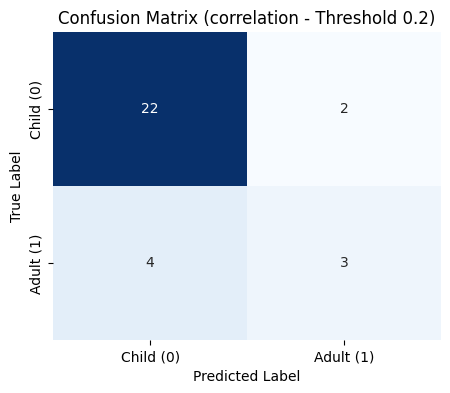


📊 Results for CORRELATION | Threshold: 0.4
✅ Accuracy: 0.8387
              precision    recall  f1-score   support

           0     0.8800    0.9167    0.8980        24
           1     0.6667    0.5714    0.6154         7

    accuracy                         0.8387        31
   macro avg     0.7733    0.7440    0.7567        31
weighted avg     0.8318    0.8387    0.8342        31



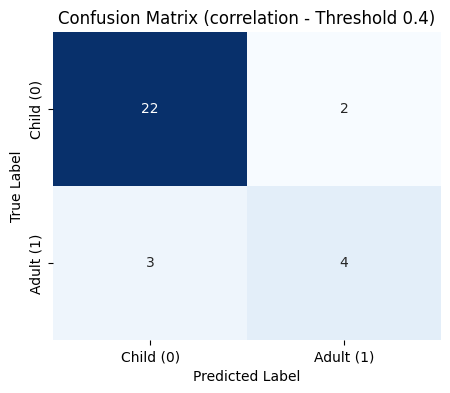


📊 Results for CORRELATION | Threshold: 0.6
✅ Accuracy: 0.8065
              precision    recall  f1-score   support

           0     0.8462    0.9167    0.8800        24
           1     0.6000    0.4286    0.5000         7

    accuracy                         0.8065        31
   macro avg     0.7231    0.6726    0.6900        31
weighted avg     0.7906    0.8065    0.7942        31



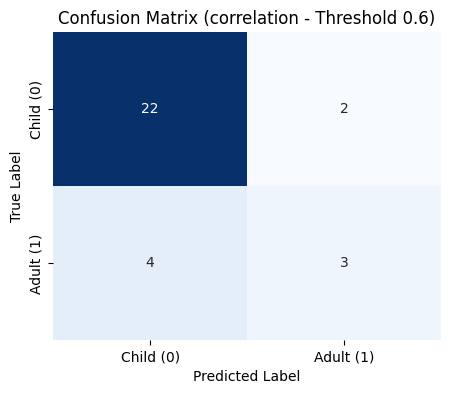


📊 Results for CORRELATION | Threshold: 0.8
✅ Accuracy: 0.8065
              precision    recall  f1-score   support

           0     0.8750    0.8750    0.8750        24
           1     0.5714    0.5714    0.5714         7

    accuracy                         0.8065        31
   macro avg     0.7232    0.7232    0.7232        31
weighted avg     0.8065    0.8065    0.8065        31



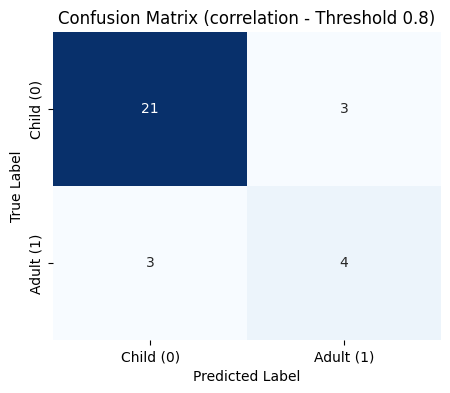


📊 Results for PARTIAL | Threshold: 0.2
✅ Accuracy: 0.7742
              precision    recall  f1-score   support

           0     0.7742    1.0000    0.8727        24
           1     0.0000    0.0000    0.0000         7

    accuracy                         0.7742        31
   macro avg     0.3871    0.5000    0.4364        31
weighted avg     0.5994    0.7742    0.6757        31



/Users/anushamourshed/miniconda3/envs/capstone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anushamourshed/miniconda3/envs/capstone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anushamourshed/miniconda3/envs/capstone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

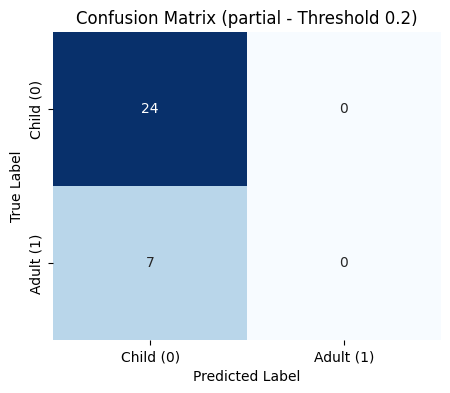


📊 Results for PARTIAL | Threshold: 0.4
✅ Accuracy: 0.7742
              precision    recall  f1-score   support

           0     0.7742    1.0000    0.8727        24
           1     0.0000    0.0000    0.0000         7

    accuracy                         0.7742        31
   macro avg     0.3871    0.5000    0.4364        31
weighted avg     0.5994    0.7742    0.6757        31



/Users/anushamourshed/miniconda3/envs/capstone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anushamourshed/miniconda3/envs/capstone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anushamourshed/miniconda3/envs/capstone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

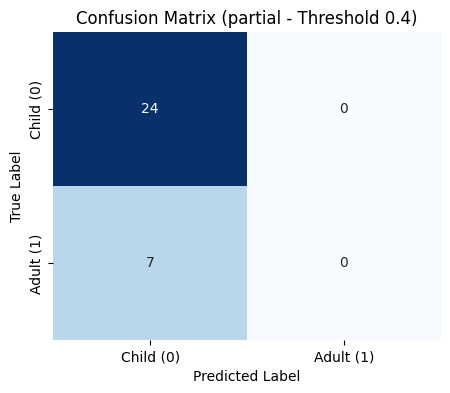


📊 Results for PARTIAL | Threshold: 0.6
✅ Accuracy: 0.7742
              precision    recall  f1-score   support

           0     0.7742    1.0000    0.8727        24
           1     0.0000    0.0000    0.0000         7

    accuracy                         0.7742        31
   macro avg     0.3871    0.5000    0.4364        31
weighted avg     0.5994    0.7742    0.6757        31



/Users/anushamourshed/miniconda3/envs/capstone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anushamourshed/miniconda3/envs/capstone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anushamourshed/miniconda3/envs/capstone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

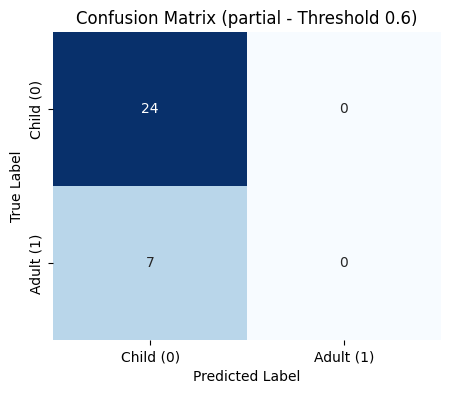


📊 Results for PARTIAL | Threshold: 0.8
✅ Accuracy: 0.7742
              precision    recall  f1-score   support

           0     0.7742    1.0000    0.8727        24
           1     0.0000    0.0000    0.0000         7

    accuracy                         0.7742        31
   macro avg     0.3871    0.5000    0.4364        31
weighted avg     0.5994    0.7742    0.6757        31



/Users/anushamourshed/miniconda3/envs/capstone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anushamourshed/miniconda3/envs/capstone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/anushamourshed/miniconda3/envs/capstone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

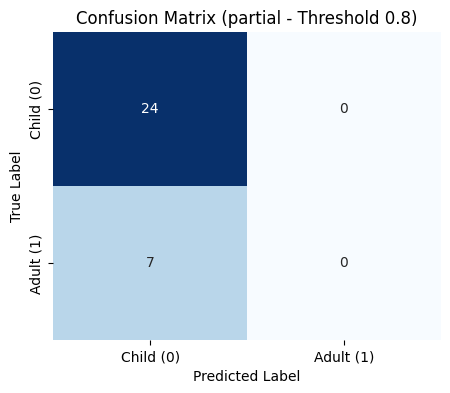


📊 Results for TANGENT | Threshold: 0.2
✅ Accuracy: 0.8387
              precision    recall  f1-score   support

           0     0.8276    1.0000    0.9057        24
           1     1.0000    0.2857    0.4444         7

    accuracy                         0.8387        31
   macro avg     0.9138    0.6429    0.6751        31
weighted avg     0.8665    0.8387    0.8015        31



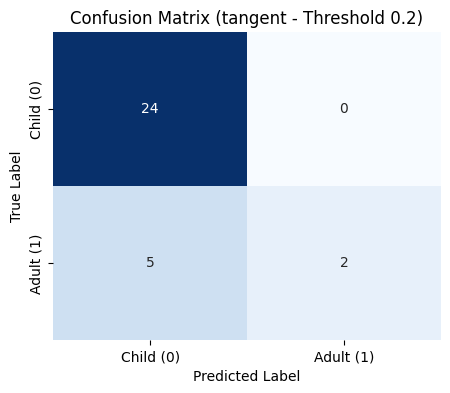


📊 Results for TANGENT | Threshold: 0.4
✅ Accuracy: 0.8710
              precision    recall  f1-score   support

           0     0.8571    1.0000    0.9231        24
           1     1.0000    0.4286    0.6000         7

    accuracy                         0.8710        31
   macro avg     0.9286    0.7143    0.7615        31
weighted avg     0.8894    0.8710    0.8501        31



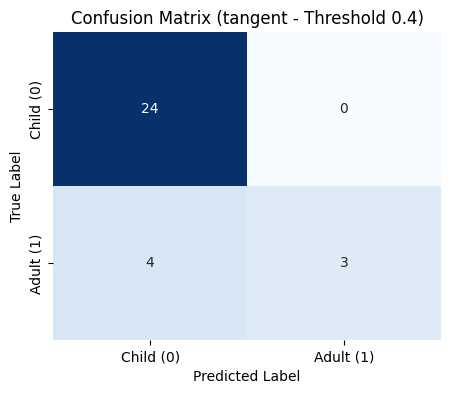


📊 Results for TANGENT | Threshold: 0.6
✅ Accuracy: 0.8387
              precision    recall  f1-score   support

           0     0.8519    0.9583    0.9020        24
           1     0.7500    0.4286    0.5455         7

    accuracy                         0.8387        31
   macro avg     0.8009    0.6935    0.7237        31
weighted avg     0.8289    0.8387    0.8215        31



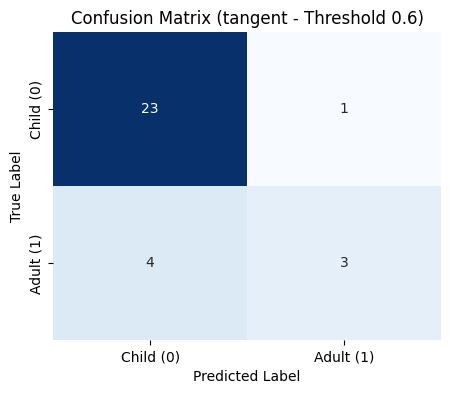


📊 Results for TANGENT | Threshold: 0.8
✅ Accuracy: 0.8710
              precision    recall  f1-score   support

           0     0.8846    0.9583    0.9200        24
           1     0.8000    0.5714    0.6667         7

    accuracy                         0.8710        31
   macro avg     0.8423    0.7649    0.7933        31
weighted avg     0.8655    0.8710    0.8628        31



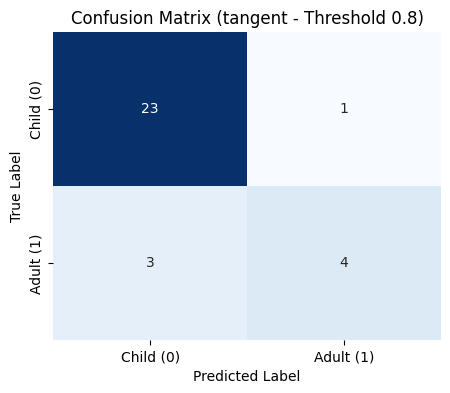

In [38]:
# --- Visualize confusion matrices and metrics for all experiments ---

from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Loop through all saved results
for result in results:
    corr_type = result['correlation_type']
    threshold = result['threshold']
    accuracy = result['accuracy']
    cm = result['confusion_matrix']
    
    print(f"\n📊 Results for {corr_type.upper()} | Threshold: {threshold}")
    print(f"✅ Accuracy: {accuracy:.4f}")
    
    # Calculate and print classification report
    # We rebuild true and predicted labels from confusion matrix manually
    # y_true: [0]*n0_true + [1]*n1_true
    # y_pred: predicted 0 or 1 based on matrix
    n0_true = cm[0, 0] + cm[0, 1]
    n1_true = cm[1, 0] + cm[1, 1]
    
    y_true = np.array([0] * n0_true + [1] * n1_true)
    y_pred = np.array([0] * cm[0, 0] + [1] * cm[0, 1] + [0] * cm[1, 0] + [1] * cm[1, 1])
    
    print(classification_report(y_true, y_pred, digits=4))

    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Child (0)', 'Adult (1)'],
                yticklabels=['Child (0)', 'Adult (1)'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix ({corr_type} - Threshold {threshold})')
    plt.show()


### 📊 GCN Classification Results Summary (Child vs Adult)

| Correlation Type | Threshold | Accuracy | Child Precision | Adult Precision | Child Recall | Adult Recall |
|------------------|-----------|----------|------------------|------------------|---------------|---------------|
| Correlation      | 0.2       | 0.8065   | 0.8462           | 0.6000           | 0.9167        | 0.4286        |
| Correlation      | 0.4       | 0.8387   | 0.8800           | 0.6667           | 0.9167        | 0.5714        |
| Correlation      | 0.5       | 0.8710   | 0.9545           | 0.6667           | 0.8750        | 0.8571        |
| Correlation      | 0.6       | 0.8065   | 0.8462           | 0.6000           | 0.9167        | 0.4286        |
| Correlation      | 0.8       | 0.8065   | 0.8750           | 0.5714           | 0.8750        | 0.5714        |
| Partial          | 0.2       | 0.7742   | 0.7742           | 0.0000           | 1.0000        | 0.0000        |
| Partial          | 0.4       | 0.7742   | 0.7742           | 0.0000           | 1.0000        | 0.0000        |
| Partial          | 0.5       | 0.7742   | 0.7742           | 0.0000           | 1.0000        | 0.0000        |
| Partial          | 0.6       | 0.7742   | 0.7742           | 0.0000           | 1.0000        | 0.0000        |
| Partial          | 0.8       | 0.7742   | 0.7742           | 0.0000           | 1.0000        | 0.0000        |
| Tangent          | 0.2       | 0.8387   | 0.8276           | 1.0000           | 1.0000        | 0.2857        |
| Tangent          | 0.4       | 0.8710   | 0.8571           | 1.0000           | 1.0000        | 0.4286        |
| Tangent          | 0.5       | 0.9032   | 0.8889           | 1.0000           | 1.0000        | 0.5714        |
| Tangent          | 0.6       | 0.8387   | 0.8519           | 0.7500           | 0.9583        | 0.4286        |
| Tangent          | 0.8       | 0.8710   | 0.8846           | 0.8000           | 0.9583        | 0.5714        |


# 13. Visualize Comparisons

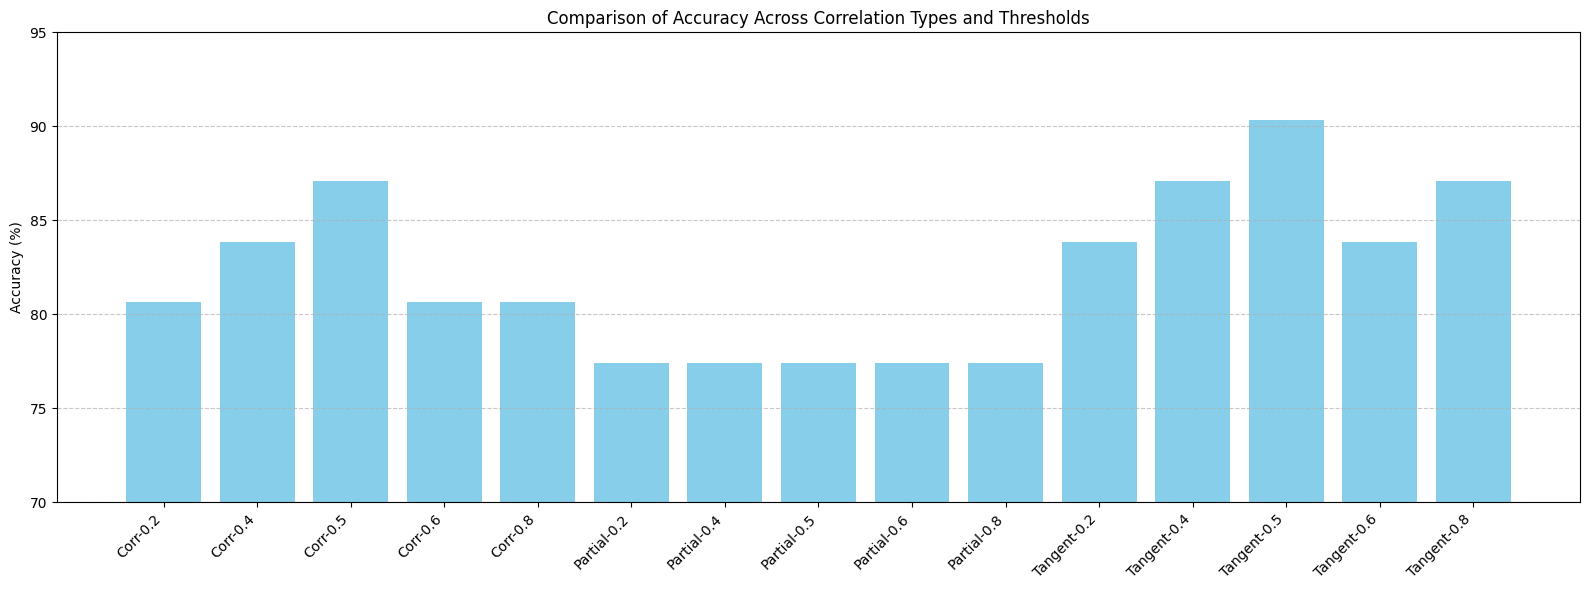

In [1]:
# --- Accuracy Bar Plot for All Correlation Types and Thresholds ---

import matplotlib.pyplot as plt

# Data
methods = [
    'Corr-0.2', 'Corr-0.4', 'Corr-0.5', 'Corr-0.6', 'Corr-0.8',
    'Partial-0.2', 'Partial-0.4', 'Partial-0.5', 'Partial-0.6', 'Partial-0.8',
    'Tangent-0.2', 'Tangent-0.4', 'Tangent-0.5', 'Tangent-0.6', 'Tangent-0.8'
]

accuracies = [
    80.65, 83.87, 87.10, 80.65, 80.65,
    77.42, 77.42, 77.42, 77.42, 77.42,
    83.87, 87.10, 90.32, 83.87, 87.10
]

# Create plot
plt.figure(figsize=(16,6))
plt.bar(methods, accuracies, color='skyblue')

# Formatting
plt.xticks(rotation=45, ha='right')
plt.ylim(70, 95)
plt.ylabel('Accuracy (%)')
plt.title('Comparison of Accuracy Across Correlation Types and Thresholds')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


✅ Best Model (Recall-Prioritized):
- Pearson Correlation (Threshold = 0.5)
- Accuracy: 0.8710
- Child Recall: 0.8750
- Adult Recall: 0.8571 (Highest adult recall among all models)

Although Tangent (0.5) has higher accuracy (0.9032), its adult recall is 0.5714, which is significantly lower. Since we prioritize not missing adults for our dataset, Pearson at 0.5 is the better choice.


# 14. Accuracies Compared with Classical Machine Learning Models

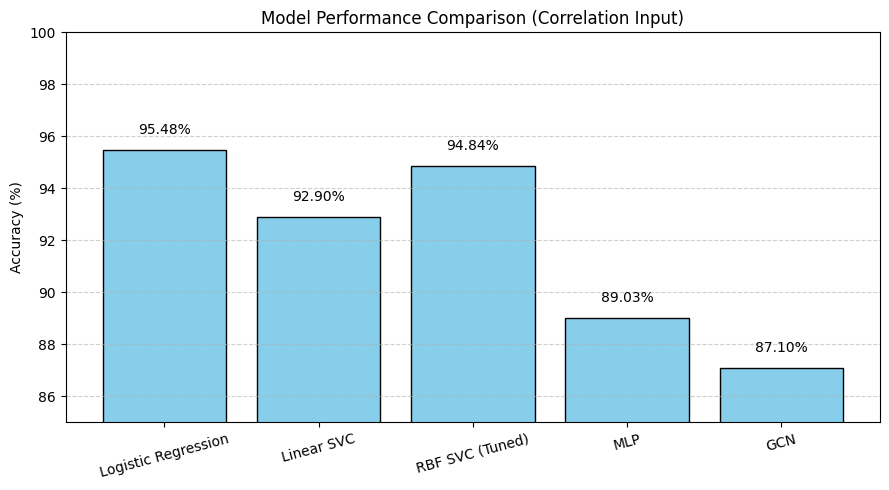

In [2]:
import matplotlib.pyplot as plt

# Model names and accuracies
models = [
    'Logistic Regression',
    'Linear SVC',
    'RBF SVC (Tuned)',
    'MLP',
    'GCN'
]
accuracies = [95.48, 92.90, 94.84, 89.03, 87.10]

# Create bar plot
plt.figure(figsize=(9, 5))
bars = plt.bar(models, accuracies, color='skyblue', edgecolor='black')

# Annotate bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{acc:.2f}%', ha='center', va='bottom', fontsize=10)

# Plot formatting
plt.ylim(85, 100)
plt.ylabel('Accuracy (%)')
plt.title('Model Performance Comparison (Correlation Input)')
plt.xticks(rotation=15)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()
